In [1]:
%load_ext autoreload
%autoreload 2
import pycountry
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import seaborn as sns
import itertools as it
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.vector_ar.dynamic import DynamicPanelVAR
%run ../src/models/geo_helpers.py
%run ../src/models/section_series.py
%load_ext rpy2.ipython
%matplotlib inline
pd.options.display.float_format = '{:,.4f}'.format

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
def get_country_name(code):
    try:
        return pycountry.countries.get(alpha_2=code.upper()).name.lower()
    except KeyError:
        return 'unknown'
    except AttributeError:
        return 'unknown'
    

In [3]:
city_locations_path = '../data/external/' +\
    'worldcitiespop.txt'

city_locations = pd.read_csv(city_locations_path, encoding = "ISO-8859-1").rename(columns={'City': 'city'})
city_locations = city_locations[city_locations['Population'] > 0] # filter for populated cities
city_locations['country'] = city_locations['Country'].apply(get_country_name)
print('Shape: {}'.format(city_locations.shape))
city_locations.head()

/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2683: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Shape: (47980, 8)


,Country,city,AccentCity,Region,Population,Latitude,Longitude,country
6,ad,andorra la vella,Andorra la Vella,7.0000,"20,430.0000",42.5000,1.5167,andorra
20,ad,canillo,Canillo,2.0000,"3,292.0000",42.5667,1.6000,andorra
32,ad,encamp,Encamp,3.0000,"11,224.0000",42.5333,1.5833,andorra
49,ad,la massana,La Massana,4.0000,"7,211.0000",42.5500,1.5167,andorra
53,ad,les escaldes,Les Escaldes,8.0000,"15,854.0000",42.5000,1.5333,andorra


In [4]:
earthquake_locations_path = '../data/external/' +\
    'earthquakes_affected_locations/earthquakes_affected_locations.csv'

earthquake_locations = pd.read_csv(earthquake_locations_path, encoding = "ISO-8859-1").drop('country', axis=1)
earthquake_locations['city'] = earthquake_locations['city'].apply(lambda c: c.lower())
print('Shape: {}'.format(earthquake_locations.shape))
earthquake_locations.head()

Shape: (2719, 12)


,id,city,latitude,longitude,geoname,year,month,day,Totaldeaths,Totalaffected,Totaldamage000US,insured_losses
0,1,takhar,36.7000,69.8000,NaN,1992,5,20,14,0,0,0
1,2,jowzan,36.7500,66.0000,Jowzjan,1994,5,1,160,100330,0,0
2,2,mazar-i-sharif,36.7500,67.0000,mazar-i-sharif,1994,5,1,160,100330,0,0
3,2,balkh,36.7501,66.8997,balkh,1994,5,1,160,100330,0,0
4,2,termez,37.2242,67.2783,NaN,1994,5,1,160,100330,0,0


In [5]:
category_cols = ['Region', 'Income group', 'Lending category']
class_path = '../data/external/' +\
    'class.csv'
world_bank_class = pd.read_csv(class_path, encoding = "ISO-8859-1", skiprows=[1])\
    .drop(['Unnamed: {}'.format(i) for i in [0,1,4]] + ['Code', 'Other'], axis=1)\
    .rename(columns={'Economy': 'country'})
    
le = LabelEncoder()
world_bank_class[category_cols] = world_bank_class[category_cols]\
    .apply(lambda c: le.fit_transform(c.astype(str)))
world_bank_class['country'] = world_bank_class['country'].apply(lambda c: str(c).lower())
world_bank_class.head()

,country,Region,Income group,Lending category
0,afghanistan,5,1,3
1,albania,1,3,2
2,algeria,3,3,2
3,american samoa,0,3,0
4,andorra,1,0,0


In [6]:
inflation_path = '../data/external/' +\
    'inflation.csv'
inflation = pd.read_csv(inflation_path, encoding = "ISO-8859-1", skiprows=[1]).rename(columns={'Country Name': 'country'})\
    .drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 61'], axis=1).set_index('country').fillna(0)

inflation = inflation[[c for c in inflation.columns if int(c) > 1992 & int(c) < 2014]].reset_index()
inflation = pd.melt(inflation, id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)])\
    .rename(columns={'variable': 'year', 'value': 'inflation'})
inflation['country'] = inflation['country'].apply(lambda c: str(c).lower())
inflation = inflation.astype({'year': 'int64', 'country': 'str'})
inflation.head()

,country,year,inflation
0,afghanistan,1993,0.0000
1,angola,1993,"1,379.4143"
2,albania,1993,85.0048
3,andorra,1993,0.0000
4,arab world,1993,9.3703


In [7]:
tot_path = '../data/external/' +\
    'terms_of_trade.csv'
terms_of_trade = pd.read_csv(tot_path, encoding = "ISO-8859-1", skiprows=[1]).rename(columns={'Country Name': 'country'})\
    .drop(['Country Code', 'Indicator Name', 'Indicator Code', 'Unnamed: 61'], axis=1).set_index('country').fillna(0)

terms_of_trade = terms_of_trade[[c for c in terms_of_trade.columns if int(c) > 1992 & int(c) < 2014]].reset_index()
terms_of_trade = pd.melt(terms_of_trade, id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)])\
    .rename(columns={'variable': 'year', 'value': 'terms_of_trade'})
terms_of_trade['country'] = terms_of_trade['country'].apply(lambda c: str(c).lower())
terms_of_trade = terms_of_trade.astype({'year': 'int64', 'country': 'str'})
terms_of_trade.head()

,country,year,terms_of_trade
0,afghanistan,1993,0.0000
1,angola,1993,0.0000
2,albania,1993,0.0000
3,andorra,1993,0.0000
4,arab world,1993,0.0000


In [8]:
imports_path = '../data/external/' +\
    'imports.csv'
imports = pd.read_csv(imports_path, encoding = "ISO-8859-1", skiprows=[1]).rename(columns={'Country Name': 'country'})\
    .drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).set_index('country').fillna(0)

imports = imports[[c for c in imports.columns if int(c) > 1992 & int(c) < 2014]].reset_index()
imports = pd.melt(imports, id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)])\
    .rename(columns={'variable': 'year', 'value': 'imports'})
imports['country'] = imports['country'].apply(lambda c: str(c).lower())
imports = imports.astype({'year': 'int64', 'country': 'str'})
imports.head()

,country,year,imports
0,afghanistan,1993,0.0000
1,angola,1993,55.3903
2,albania,1993,62.2925
3,andorra,1993,0.0000
4,arab world,1993,31.9900


In [9]:
exports_path = '../data/external/' +\
    'exports.csv'
exports = pd.read_csv(exports_path, encoding = "ISO-8859-1", skiprows=[1]).rename(columns={'Country Name': 'country'})\
    .drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).set_index('country').fillna(0)

exports = exports[[c for c in exports.columns if int(c) > 1992 & int(c) < 2014]].reset_index()
exports = pd.melt(exports, id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)])\
    .rename(columns={'variable': 'year', 'value': 'exports'})
exports['country'] = exports['country'].apply(lambda c: str(c).lower())
exports = exports.astype({'year': 'int64', 'country': 'str'})
exports.head()

,country,year,exports
0,afghanistan,1993,0.0000
1,angola,1993,53.9033
2,albania,1993,15.4225
3,andorra,1993,0.0000
4,arab world,1993,28.5362


In [262]:
viv_lum_path = '../data/external/viviana_all_lum.csv'
viv_lum = pd.read_csv(viv_lum_path, delimiter=';', encoding='ISO-8859-1')

value_cols = [c for c in viv_lum.columns if c[0] == 'f' and '_' in c] 

viv_lum = viv_lum[viv_lum['iso_a2'] != np.nan]
viv_lum['country'] = viv_lum['iso_a2'].apply(get_country_name)
viv_lum.head()


,adm1_code,Shape_Leng,Shape_Area,diss_me,adm1_code_,iso_3166_2,wikipedia,sr_sov_a3,sr_adm0_a3,iso_a2,...,f18_2013,f14_2000,f14_2001,f14_2002,f14_2003,f15_2005,f15_2006,f15_2007,f16_2006.1,country
0,ABW+00?,0.6524,0.0141,10000,ABW+00?,AW-,NaN,NL1,ABW,AW,...,"7,371.0000","7,225.0000","7,584.0000","6,901.0000","7,544.0000","6,790.0000","6,492.0000","6,384.0000","7,335.0000",aruba
1,AFG-1741,7.0273,2.0373,1741,AFG-1741,AF-,NaN,AFG,AFG,AF,...,793.0000,283.0000,360.0000,345.0000,484.0000,649.0000,466.0000,409.0000,592.0000,afghanistan
2,AFG-1742,14.2238,5.4214,1742,AFG-1742,AF-,NaN,AFG,AFG,AF,...,"22,192.0000","1,774.0000","1,718.0000","2,313.0000","3,805.0000","9,462.0000","10,448.0000","11,835.0000","6,432.0000",afghanistan
3,AFG-1743,7.6222,1.7464,1743,AFG-1743,AF-,NaN,AFG,AFG,AF,...,255.0000,0.0000,12.0000,0.0000,70.0000,277.0000,203.0000,250.0000,180.0000,afghanistan
4,AFG-1744,7.4299,1.6154,1744,AFG-1744,AF-,NaN,AFG,AFG,AF,...,"19,733.0000","3,172.0000","1,990.0000","4,527.0000","3,954.0000","8,471.0000","6,229.0000","6,201.0000","8,015.0000",afghanistan


In [263]:
region2city = viv_lum[['name','adm1_code']]
region2city['city'] = viv_lum.name.astype(str).apply(lambda c: c.lower())
region2city = region2city.drop('name', axis=1)
region2city.head()

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,adm1_code,city
0,ABW+00?,abw-00 (aruba aggregation)
1,AFG-1741,badghis
2,AFG-1742,hirat
3,AFG-1743,bamyan
4,AFG-1744,balkh


In [275]:
region_lum_cols = value_cols + ['adm1_code']
region_lum = viv_lum[region_lum_cols].set_index(['adm1_code']).rename(columns=lambda x: x[-4:])
region_lum = pd.melt(region_lum.reset_index(), id_vars=['adm1_code'], value_vars=[str(y) for y in range(1993,2014)]).rename(columns={
    'variable': 'year',
    'value': 'region_sum_lum'
}).groupby(['adm1_code','year']).sum().reset_index().astype({'year': 'int64', 'adm1_code': 'str'}).sort_values(['year','adm1_code'])
region_lum.head()

,adm1_code,year,region_sum_lum
0,ABW+00?,1993,"6,232.0000"
21,AFG-1741,1993,359.0000
42,AFG-1742,1993,495.0000
63,AFG-1743,1993,0.0000
84,AFG-1744,1993,"8,461.0000"


In [270]:
country_lum_cols = value_cols + ['iso_a2','country']
country_lum = viv_lum[country_lum_cols].set_index(['country', 'iso_a2']).rename(columns=lambda x: x[-4:])
country_lum = pd.melt(country_lum.reset_index().set_index('iso_a2'), id_vars=['country'], value_vars=[str(y) for y in range(1993,2014)]).rename(columns={
    'variable': 'year',
    'value': 'country_sum_lum'
}).groupby(['country','year']).sum().reset_index().astype({'year': 'int64', 'country': 'str'}).sort_values(['year','country'])
country_lum.head()

,country,year,country_sum_lum
0,afghanistan,1993,"18,505.0000"
21,albania,1993,"30,400.0000"
42,algeria,1993,"1,459,588.0000"
63,american samoa,1993,"2,346.0000"
84,andorra,1993,"11,281.0000"


In [380]:
%run ../src/models/section_series.py
def create_panel(allow_lazy=False):
    annual_frames = []
    le = LabelEncoder()
    for year in range(1993, 2014):
        print('Loading data for year {}'.format(year))
        try:
            if allow_lazy is True:
                annual_frames.append(pd.read_csv('../data/processed/section_series_sum_small/{}.csv'.format(year)).set_index(['year','city']))
            else:
                raise FileNotFoundError()
        except FileNotFoundError:
            earthquake_locations_in_year = earthquake_locations[earthquake_locations.year == year]
            earthquake_cities_in_year = earthquake_locations_in_year['city'].unique()
            df = pd.merge(city_locations, earthquake_locations_in_year, on='city', how='left')
            df = df.fillna(0).reset_index().groupby('city').agg({
                'Totaldeaths': 'sum',
                'Totalaffected': 'sum',
                'Totaldamage000US': 'sum',
                'insured_losses': 'sum',
                'Latitude': 'first',
                'Longitude': 'first',
                'country': 'first',
                'city': 'first'
            }).set_index('city').rename(columns={
                'Latitude': 'latitude',
                'Longitude': 'longitude',
                'Totaldeaths': 'total_deaths',
                'Totalaffected': 'total_affected',
                'Totaldamage000US': 'total_damage_usd'
            }).reset_index()
            df['year'] = year
            df['earthquake_dummy'] = df.city.map(lambda c: c in earthquake_cities_in_year)
            df = df.merge(world_bank_class, on='country', how='left')
            df = df.merge(region2city, on='city', how='left')
            df = df.merge(region_lum, on=['year','adm1_code'], how='left') #shortens the data a lot
            df = df.merge(terms_of_trade, on=['year','country'], how='left')
            df = df.merge(country_lum, on=['year','country'], how='left')
            df = df.merge(inflation, on=['year','country'], how='left')
            df = df.merge(imports, on=['year','country'], how='left')
            df = df.merge(exports, on=['year','country'], how='left')
            target_coords_list = [{'lat': r[0],'lng': r[1]} for r
                in df[['latitude', 'longitude']].values]
            series_loader = SectionSeriesLoader(
                img_shape=(50, 50),
                start_year=year,
                end_year=year,
                SRC_PATH='../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/*.npz')
            df['sum_lum'] = series_loader.load_multiple_sums(target_coords_list).reshape(-1)
            df['country'] = le.fit_transform(df['country'])
            df = df.astype({'city': str}).groupby(['city','year']).first()
            df.to_csv('../data/processed/section_series_sum_small/{}.csv'.format(year))
            annual_frames.append(df)

    panel = xr.Dataset.from_dataframe(pd.concat(annual_frames))
    panel.to_dataframe().to_csv('../data/processed/section_series_sum_small/panel.csv')
    # # del annual_frames
    return panel


panel = create_panel()

Loading data for year 1993
['../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F101993.v4b_web.stable_lights.avg_vis.tif.npz']
Loading file ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F101993.v4b_web.stable_lights.avg_vis.tif.npz
Loading data for year 1994
['../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121994.v4b_web.stable_lights.avg_vis.tif.npz']
Loading file ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121994.v4b_web.stable_lights.avg_vis.tif.npz
Loading data for year 1995
['../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121995.v4b_web.stable_lights.avg_vis.tif.npz']
Loading file ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121995.v4b_web.stable_lights.avg_vis.tif.npz
Loading data for year 1996
['../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121996.v4b_web.stable_lights.avg_vis.tif.npz']
Loading file ../data/raw/Version_4_DMSP-OLS_Nighttime_Lights_Time_Series/F121996.v4b_web.stable

In [386]:
panel_df = panel.to_dataframe()
(panel_df.reset_index().groupby('city').sum().earthquake_dummy > 0).shape
# panel_df.sort_values('total_deaths', ascending=False).head()

(43183,)

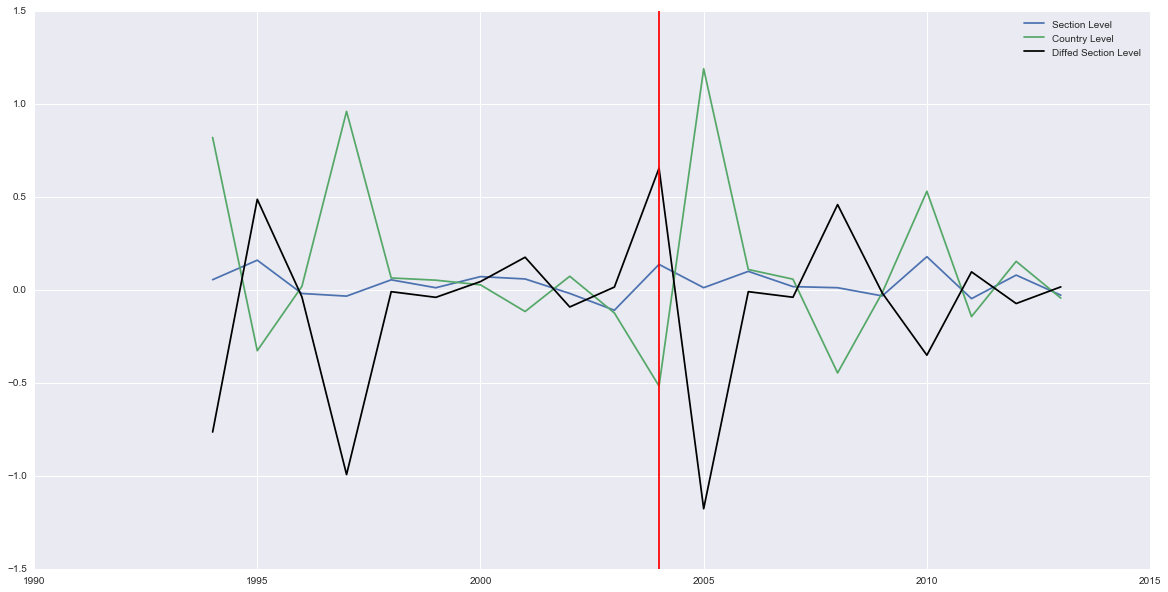

In [364]:
df = panel.sel(city='port-au-prince').to_dataframe().fillna(0).drop(['city','latitude','longitude'],axis=1)
plt.figure(figsize=(20,10))
plt.plot(df.sum_lum.pct_change(), label='Section Level')
plt.plot(df.country_sum_lum.pct_change(), label='Country Level')
plt.plot(df.sum_lum.pct_change() - df.country_sum_lum.pct_change(), label='Diffed Section Level', c='black')
for i, row in df[df['earthquake_dummy'] == True].iterrows():
    plt.axvline(x=row.name, c='r')
    
plt.legend()
plt.show()

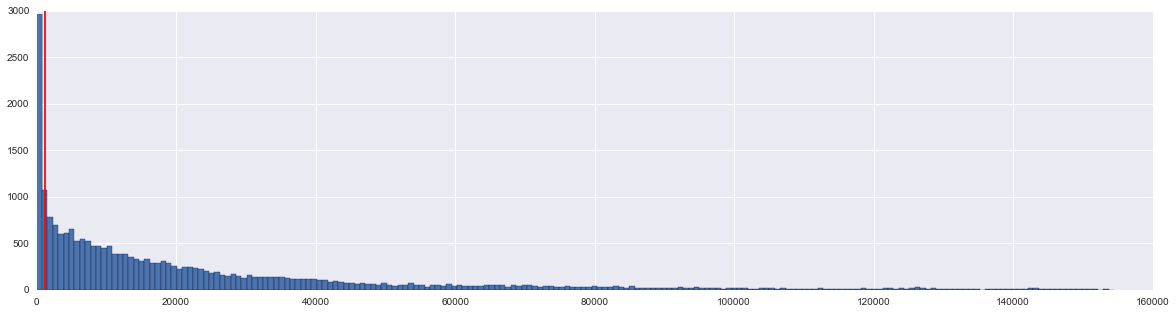

In [351]:
threshold = 50 * 50 * 0.5
plt.figure(figsize=(20,5))
plt.hist(panel_df.sum_lum, bins=200)
plt.axvline(threshold, c='r')
selected_cities = panel_df[panel_df['sum_lum'] > threshold].reset_index()['city'].unique()
plt.show()

### Diff by region level

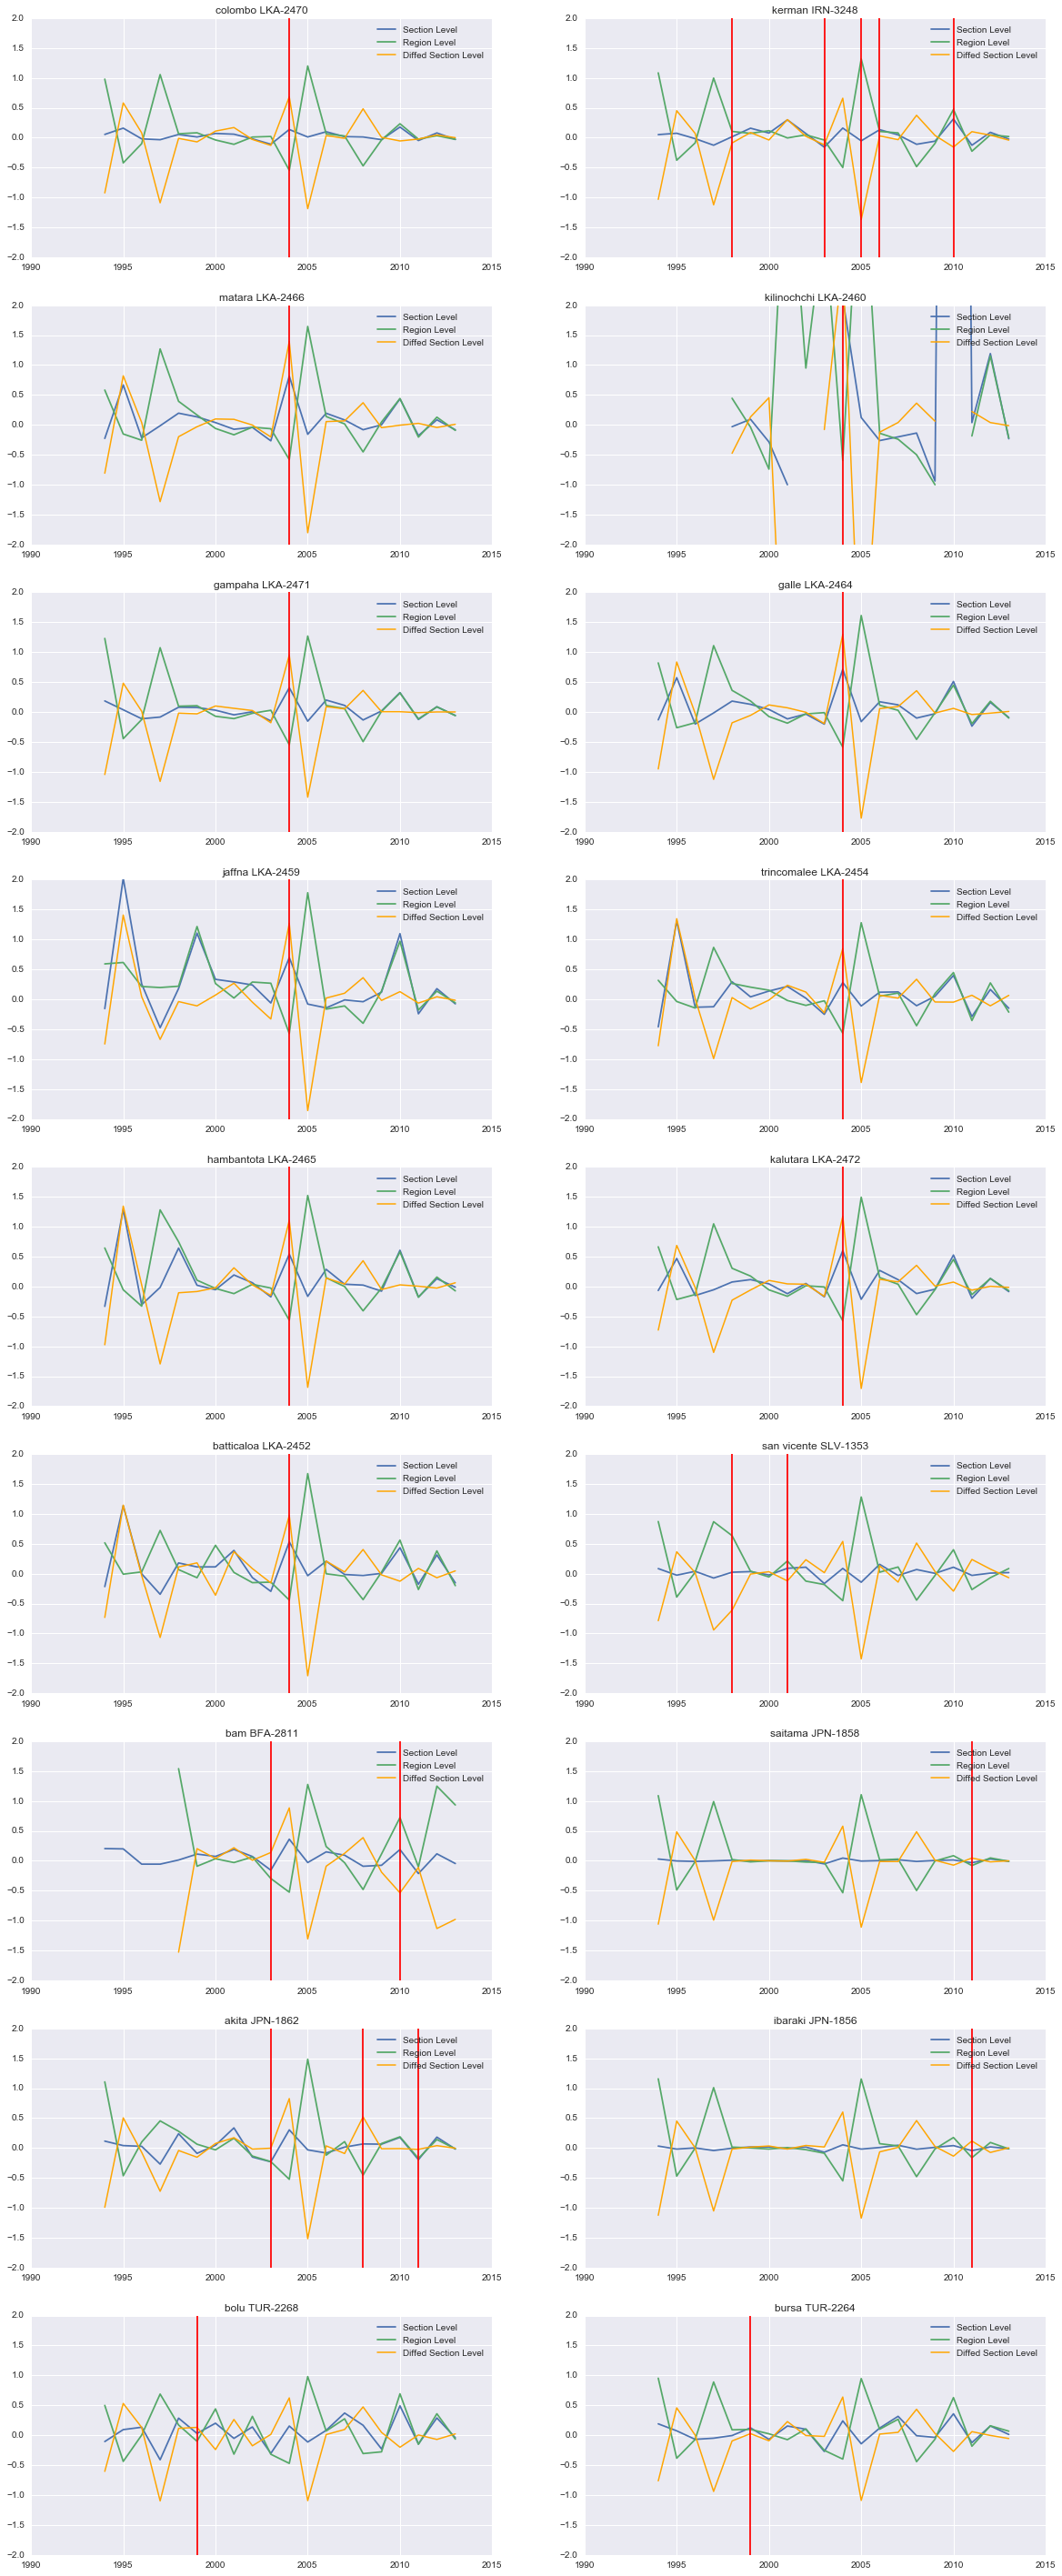

In [377]:
plot_cities = panel.sel(city=selected_cities).to_dataframe().sort_values('total_deaths', ascending=False).reset_index()['city'].unique()[:18]
fig, axs = plt.subplots(9,2,figsize=(20,50))

for i, ax in enumerate(axs.flat):
    df = panel.sel(city=plot_cities[i]).to_dataframe().fillna(0).drop(['city','latitude','longitude'],axis=1)
    ax.plot(df.sum_lum.pct_change(), label='Section Level')
    ax.plot(df.region_sum_lum.pct_change(), label='Region Level')
    ax.plot(df.sum_lum.pct_change() - df.region_sum_lum.pct_change(), label='Diffed Section Level', c='orange', lw=1.5)
    ax.set_title(plot_cities[i] + ' ' + df.adm1_code.iloc[0])
    for i, row in df[df['earthquake_dummy'] == True].iterrows():
        ax.axvline(x=row.name, c='r')
        
    ax.legend()
    ax.set_ylim([-2,2])
    
plt.show()

### Diff by country level

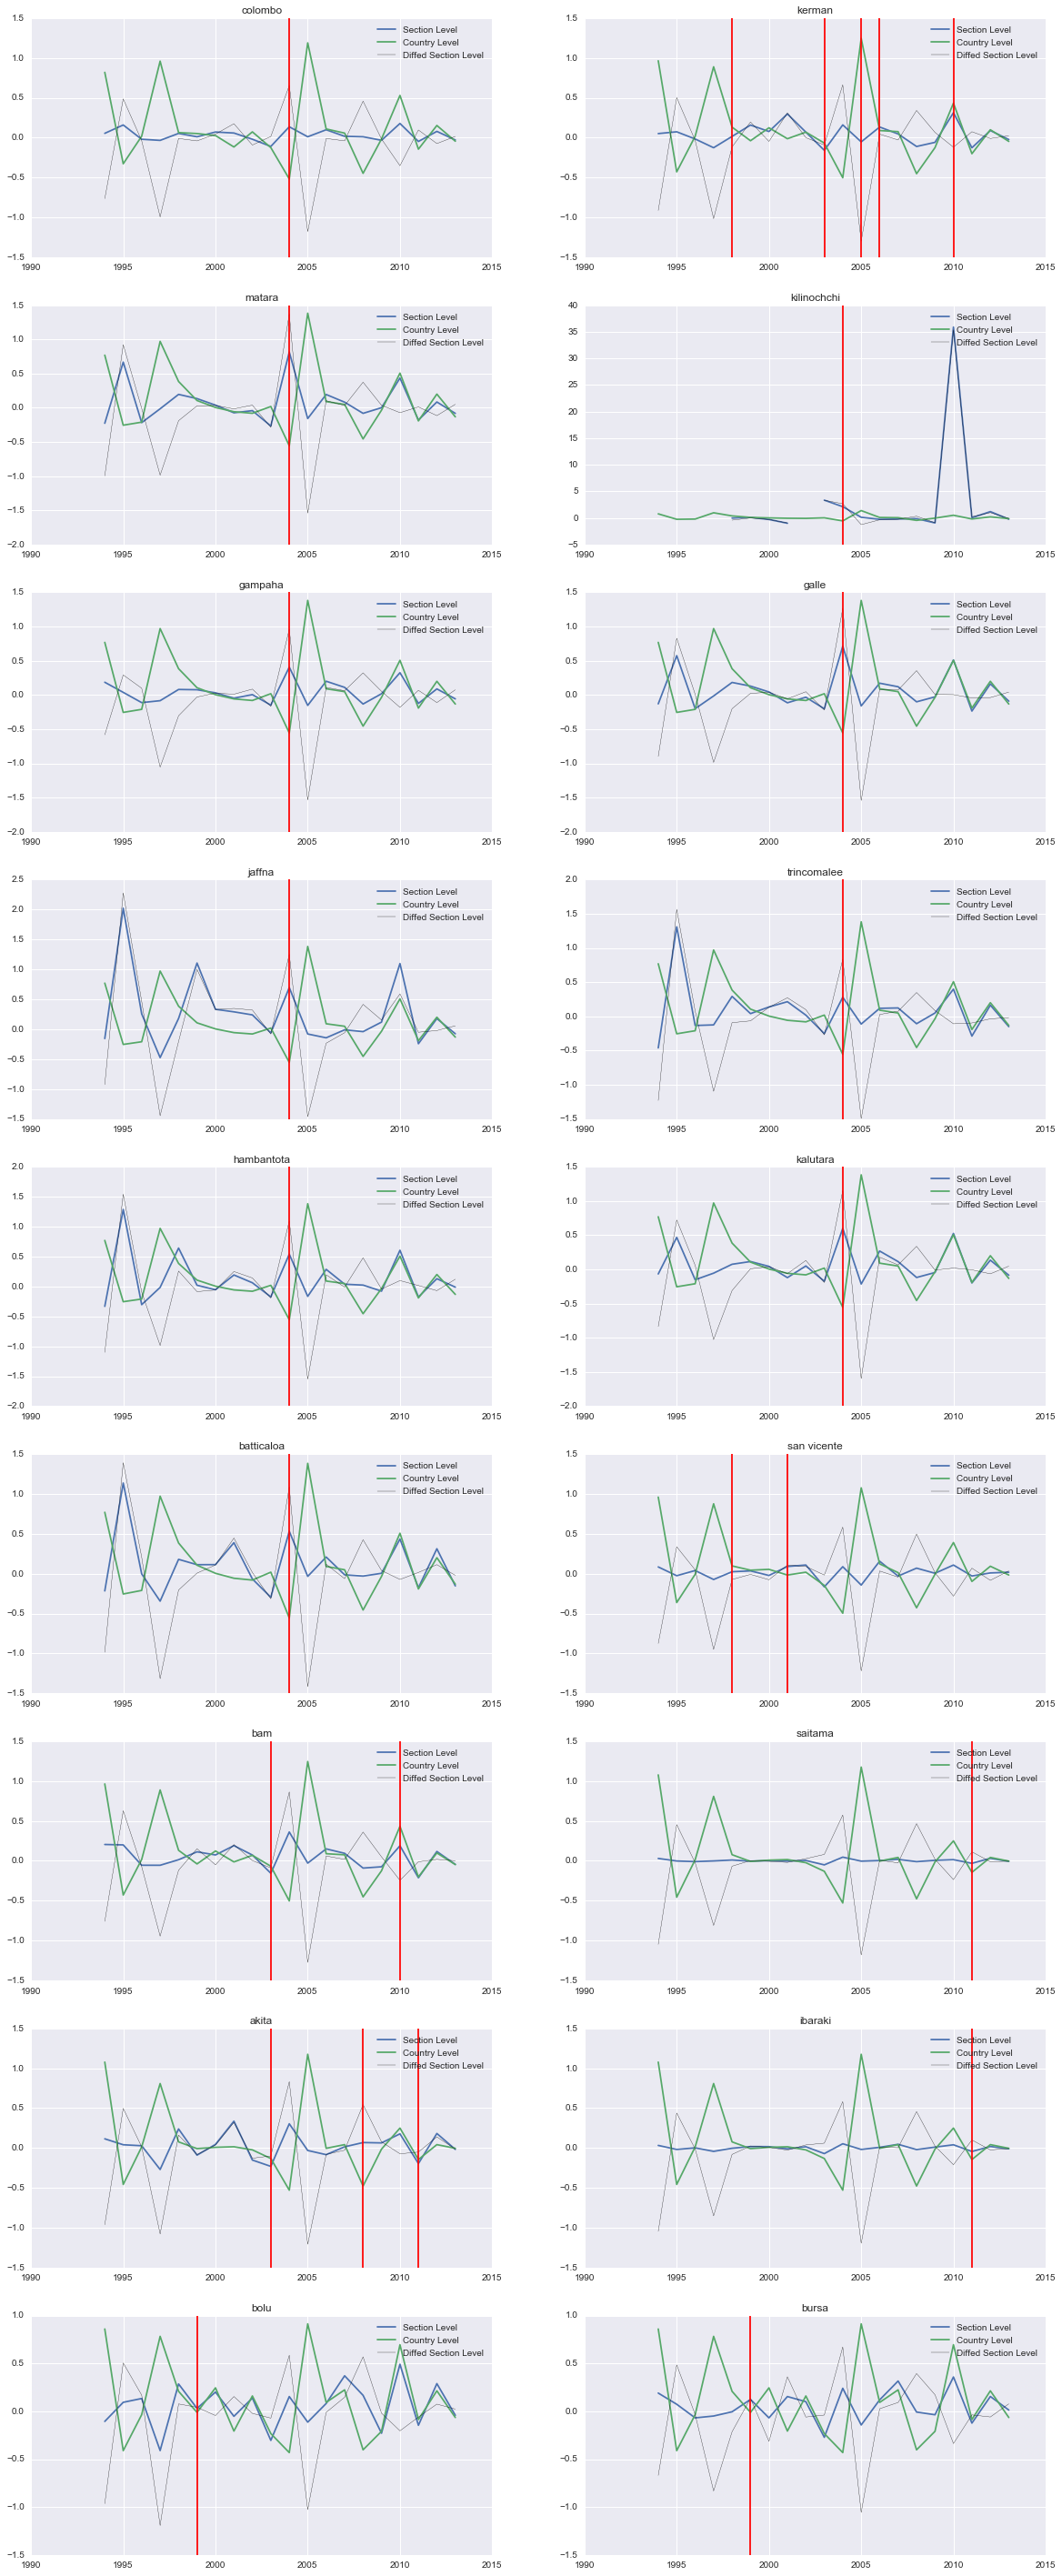

In [388]:
plot_cities = panel.sel(city=selected_cities).to_dataframe().sort_values('total_deaths', ascending=False).reset_index()['city'].unique()[:18]
fig, axs = plt.subplots(9,2,figsize=(20,50))

for i, ax in enumerate(axs.flat):
    df = panel.sel(city=plot_cities[i]).to_dataframe().fillna(0).drop(['city','latitude','longitude'],axis=1)
    ax.plot(df.sum_lum.pct_change(), label='Section Level')
    ax.plot(df.country_sum_lum.pct_change(), label='Country Level')
    ax.plot(df.sum_lum.pct_change() - df.country_sum_lum.pct_change(), label='Diffed Section Level', c='black', lw=.3)
    ax.set_title(plot_cities[i])
    for i, row in df[df['earthquake_dummy'] == True].iterrows():
        ax.axvline(x=row.name, c='r')
        
    ax.legend()
    
plt.show()

### Diff by global

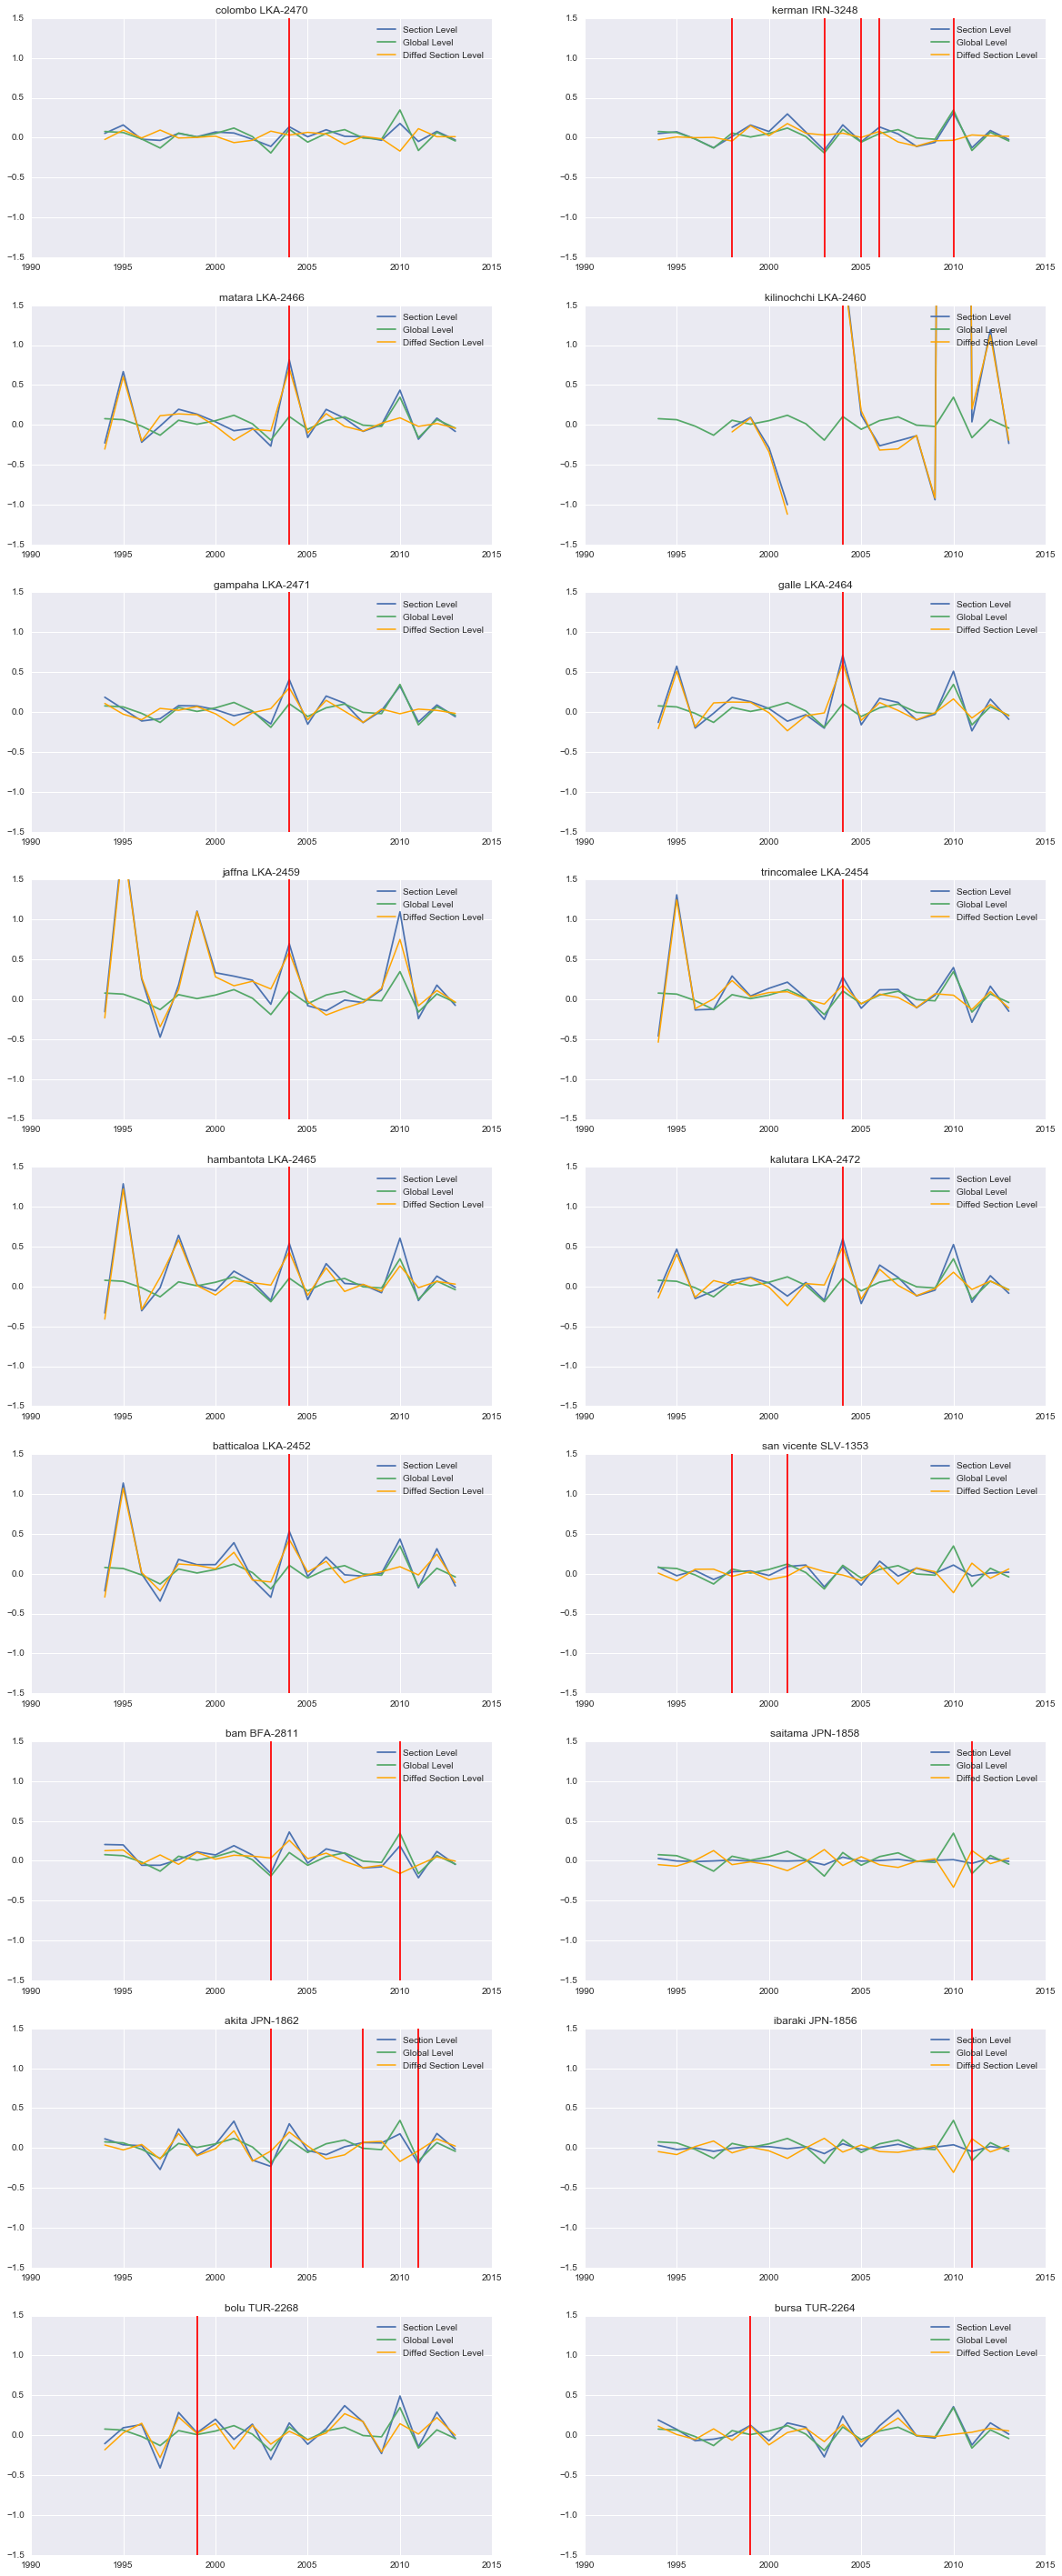

In [387]:
plot_cities = panel.sel(city=selected_cities).to_dataframe().sort_values('total_deaths', ascending=False).reset_index()['city'].unique()[:18]
fig, axs = plt.subplots(9,2,figsize=(20,50))
global_pct_change = panel_df.reset_index().groupby('year').sum().sum_lum.pct_change()

for i, ax in enumerate(axs.flat):
    df = panel.sel(city=plot_cities[i]).to_dataframe().fillna(0).drop(['city','latitude','longitude'],axis=1)
    ax.plot(df.sum_lum.pct_change(), label='Section Level')
    ax.plot(global_pct_change, label='Global Level')
    ax.plot(df.sum_lum.pct_change() - global_pct_change, label='Diffed Section Level', c='orange', lw=1.5)
    ax.set_title(plot_cities[i] + ' ' + df.adm1_code.iloc[0])
    for i, row in df[df['earthquake_dummy'] == True].iterrows():
        ax.axvline(x=row.name, c='r')
        
    ax.legend()
    ax.set_ylim([-1.5,1.5])
    
plt.show()